# Задание лабораторной работы

## Блок 1. Загрузить и предобработать датасет

* Нормализовать данные для их приведения к диапазону [0, 1].
* Разделить данные на обучающую и тестовую выборки.
* Визуализировать данные и изучить их структуру.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE

# 1. Подготовка данных (взяли данные MNIST)

# # Аугментация для обучающих данных
# train_transform = transforms.Compose([
#     transforms.RandomRotation(20),  # Поворот на 20 градусов
#     transforms.RandomResizedCrop(28, scale=(0.95, 1.1)),  # Случайное масштабирование с сохранением размера
#     transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
# ])

# # Преобразования для тестовых данных (без аугментации)
# test_transform = transforms.Compose([
#     transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
# ])

# # разделить данные на train и test
# trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
# testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование в тензор и нормализация в [0, 1]
])

# разделить данные на train и test
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using downloaded and verified file: ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



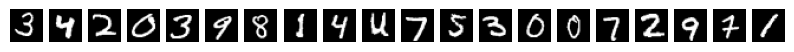

In [3]:
# визуализация данных
def visualize_data(loader, num_images=10):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

visualize_data(trainloader, 20)

## Блок 3. Реализация автокодировщика (AE):

* Создать классический автокодировщик для MNIST.
* Провести обучение и визуализировать результаты реконструкции.


In [63]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def visualize_ae_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.view(images.size(0), -1)
    images_tensor = images.to(device)

    # Реконструкция с помощью AE
    model.eval()
    with torch.no_grad():
        reconstructed = model(images_tensor).detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28).numpy(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return images.numpy(), reconstructed


def visualize_latent_space_ae(loader, model, num_images=1000, num_batches=5):
    """
    Визуализация латентного пространства AE с использованием нескольких батчей.
    """
    model.eval()
    latent_list = []
    labels_list = []

    # Проходим по нескольким батчам
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break

        images = images.view(images.size(0), -1).to(device)  # Преобразуем в тензор и перемещаем на устройство

        # Получаем латентное пространство с помощью энкодера
        with torch.no_grad():
            latent = model.encoder(images).detach().cpu().numpy()  # Латентное пространство

        latent_list.append(latent)
        labels_list.append(labels)

    # Объединяем данные из всех батчей
    latent = np.concatenate(latent_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Если размерность латентного пространства больше 2, используем t-SNE
    if latent.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42)
        latent_2d = tsne.fit_transform(latent[:num_images])  # Уменьшаем размерность
    else:
        latent_2d = latent[:num_images]

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:num_images], cmap='tab10', s=5)
    plt.colorbar()
    plt.title("AE Latent Space")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Инициализация модели и оптимизатора
model_ae = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.001)

# Обучение модели
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for data in progress_bar:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        output = model_ae(img)
        loss = criterion(output, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    # tqdm.write(f'Epoch {epoch+1}, Loss: {loss.item():.3f}')

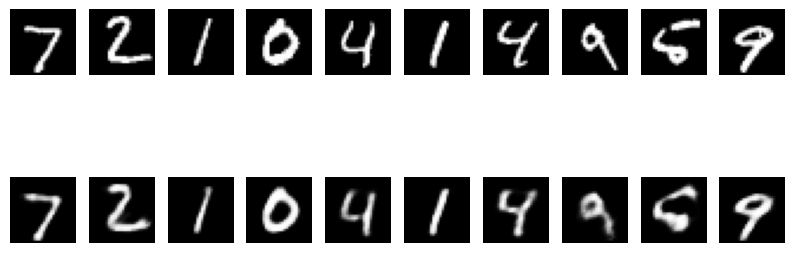

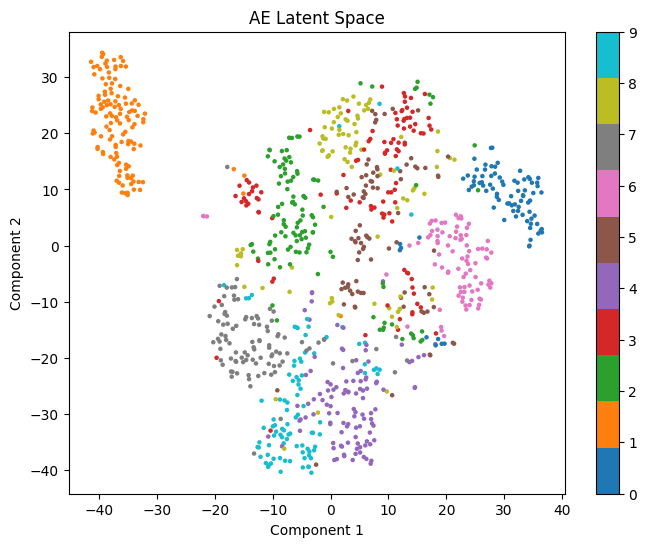

In [64]:
original_ae, recon_ae = visualize_ae_reconstruction(testloader, model_ae)
visualize_latent_space_ae(testloader, model_ae, num_batches=1000)

## Блок 4. Реализация вариационного автокодировщика (VAE):
* Реализовать архитектуру VAE.
* Провести обучение и визуализировать латентное пространство.


In [109]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # энкодер переводит изображение MNIST из размерности 28х28 в 64 для сохранения только важных признаков
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )

        # задаем среднее и дисперсию для моделирования латентного пространство как гауссового распределение
        # среднее значение
        self.fc_mu = nn.Linear(64, latent_dim)  # Используем latent_dim
        # логарифм дисперсии
        self.fc_logvar = nn.Linear(64, latent_dim)  # Используем latent_dim

        # декодер
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        """
        Кодирование входных данных в латентное пространство.
        Возвращает mu и logvar.
        """
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        """
        Моделируем латентное пространство как гауссово распределение.
        Возвращает латентный вектор z.
        """
        # стандартное отклонение
        std = torch.exp(0.5 * logvar)
        # шум из нормального распределения
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """
        Декодирование латентного вектора z в изображение.
        """
        return self.decoder(z)

    def forward(self, x):
        """
        Прямой проход через VAE.
        Возвращает реконструированное изображение, mu и logvar.
        """
        # кодирование в латентное пространство
        mu, logvar = self.encode(x.view(-1, 28*28))
        # репараметризация
        z = self.reparameterize(mu, logvar)
        # декодирование и возврат параметров
        return self.decode(z), mu, logvar

# функция потерь для VAE
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Реконструкционная ошибка
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL-дивергенция
    # beta - гиперпараметр, который контролирует вклад KLD в общую ошибку
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD , BCE, KLD

# обучение модели
def train(model, epoch, beta=1.0):
    model.train()
    train_loss = 0

    BCE_per_epoch = []
    KLD_per_epoch = []

    # Обертываем trainloader в tqdm для отображения прогресса
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}', leave=False)
    for data, _ in progress_bar:

        data = data.to(device)
        optimizer.zero_grad()
        # прямой проход
        recon_batch, mu, logvar = model(data)
        # считаем loss
        loss, BCE, KLD = loss_function(recon_batch, data, mu, logvar, beta)
        BCE_per_epoch.append(BCE.item())
        KLD_per_epoch.append(KLD.item())

        # обратное распространение
        loss.backward()
        train_loss += loss.item()
        # обновление весов
        optimizer.step()

# Визуализация латентного пространства
def visualize_latent_space(loader, model):
    model.eval()
    all_mu = []  # Список для хранения всех mu
    all_labels = []  # Список для хранения всех меток

    with torch.no_grad():
        for data in loader:
            img, labels = data
            img = img.view(img.size(0), -1).to(device)  # Преобразуем и перемещаем на устройство
            mu, _ = model.encode(img)  # Получаем mu из энкодера
            all_mu.append(mu.cpu().numpy())  # Сохраняем mu
            all_labels.append(labels.cpu().numpy())  # Сохраняем метки

    # Объединяем данные из всех батчей
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title("Латентное пространство VAE (2D)")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.show()

def visualize_vae_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.view(images.size(0), -1)
    images_tensor = images.to(device)

    # Реконструкция с помощью VAE
    model.eval()
    with torch.no_grad():
        reconstructed, _, _ = model(images_tensor)
        reconstructed = reconstructed.detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28).numpy(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return images.numpy(), reconstructed

# инициализация модели и оптимизатора
model_vae = VAE(latent_dim=32).to(device)
optimizer = optim.Adam(model_vae.parameters(), lr=1e-3)

# Обучение модели
epochs = 10
for epoch in range(1, epochs + 1):
    train(model_vae, epoch, 0.6)

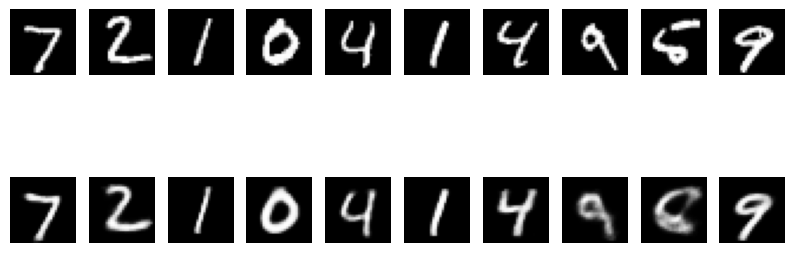

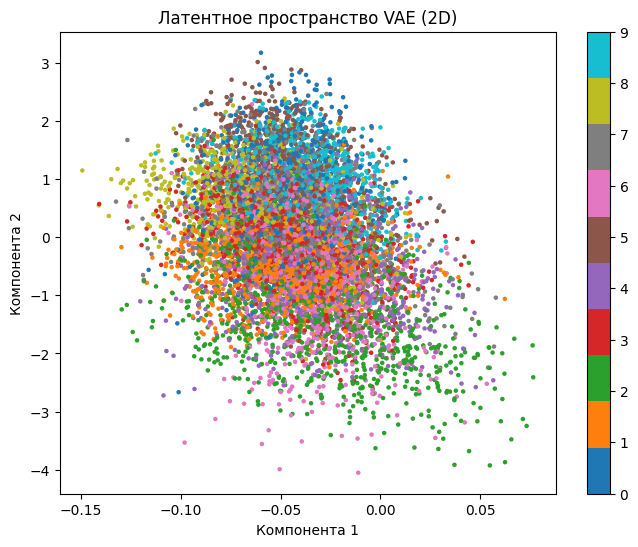

In [110]:
# визуализация реконструкции после обучения
original_vae, recon_vae = visualize_vae_reconstruction(testloader, model_vae)
visualize_latent_space(testloader, model_vae)

## Блок 5. Сравнение PCA, AE и VAE:
* Реализовать PCA для уменьшения размерности данных.
* Сравнить результаты реконструкции данных между PCA, AE и VAE.
* Оценить латентное пространство и вычислить метрики качества.


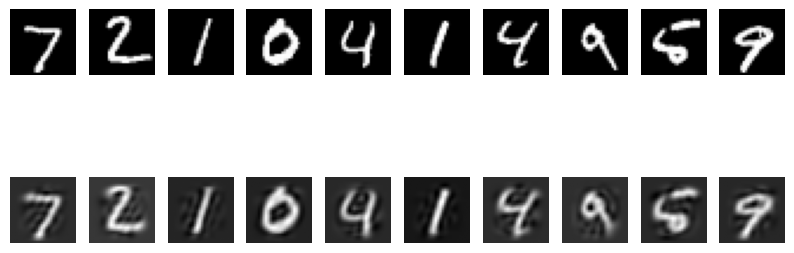

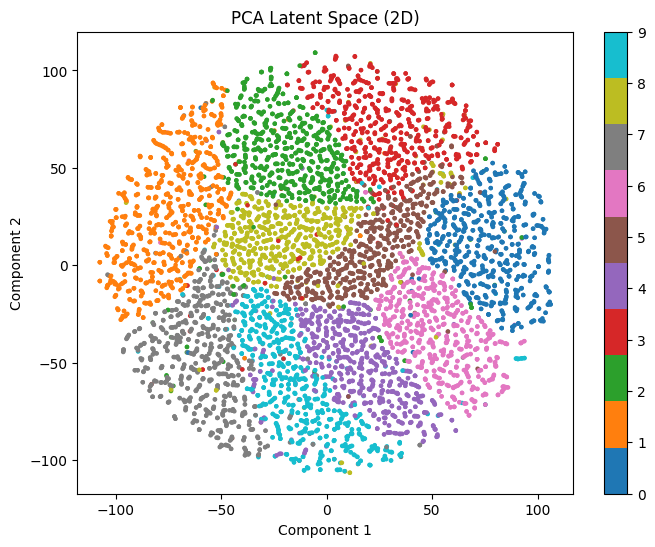

In [67]:
from sklearn.decomposition import PCA

def visualize_pca_reconstruction(original_data, model, num_images=10):
    # Реконструкция с помощью PCA
    latent = pca.transform(original_data)
    reconstructed = model.inverse_transform(latent)

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_data[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

    return original_data, reconstructed


def visualize_latent_space_pca(model, data, labels, num_images=10):
    """
    Визуализация латентного пространства PCA.
    """
    # Получаем латентное пространство с помощью PCA
    latent = model.transform(data)

    # Если размерность латентного пространства больше 2, используем t-SNE
    if latent.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=2)
        latent_2d = tsne.fit_transform(latent[:num_images])  # Уменьшаем размерность
    else:
        latent_2d = latent[:num_images]  # Используем как есть, если размерность 2

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:num_images], cmap='tab10', s=5)
    plt.colorbar()
    plt.title("PCA Latent Space (2D)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Преобразование данных в одномерный массив
x_train_flat = trainset.data.numpy().reshape(len(trainset), -1)
x_test_flat = testset.data.numpy().reshape(len(testset), -1)

# Реализация PCA
pca = PCA(n_components=64)
x_train_pca = pca.fit_transform(x_train_flat)  # Обучение PCA на тренировочных данных
x_test_pca = pca.transform(x_test_flat)  # Применение PCA к тестовым данным

# Обратное преобразование для визуализации реконструкции
x_train_reconstructed = pca.inverse_transform(x_train_pca)
x_test_reconstructed = pca.inverse_transform(x_test_pca)

# Визуализация реконструкции PCA
original_pca, recon_pca = visualize_pca_reconstruction(x_test_flat, pca)
visualize_latent_space_pca(pca, x_test_flat, testset.targets.numpy(), 60000)

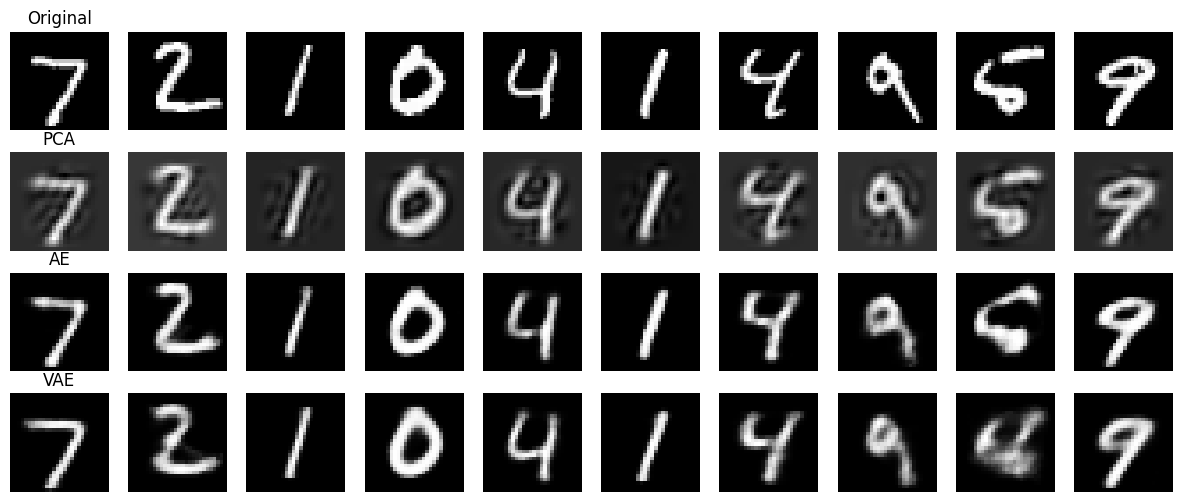

In [68]:
def compare_reconstructions(original, pca_recon, ae_recon, vae_recon, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):

        plt.subplot(4, num_images, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("Original")
        plt.axis('off')

        plt.subplot(4, num_images, num_images + i + 1)
        plt.imshow(pca_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("PCA")
        plt.axis('off')

        plt.subplot(4, num_images, 2 * num_images + i + 1)
        plt.imshow(ae_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("AE")
        plt.axis('off')

        plt.subplot(4, num_images, 3 * num_images + i + 1)
        plt.imshow(vae_recon[i].reshape(28, 28), cmap='gray')
        if i == 0:
          plt.title("VAE")
        plt.axis('off')
    plt.show()

# Визуализация сравнения реконструкций
compare_reconstructions(original_pca, recon_pca, recon_ae, recon_vae)

In [70]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Функция для вычисления MSE
def calculate_mse(original, reconstructed):
    return mean_squared_error(original, reconstructed)

# Вычисление метрик
for data, name, eval in zip([original_ae, original_vae, original_pca], ["AE", "VAE", 'PCA'], [recon_ae, recon_vae, recon_pca]):

  mse_val = calculate_mse(data, eval)

  print(f"MSE {name}: {mse_val:>6.2f}")

MSE AE:   0.01
MSE VAE:   0.02
MSE PCA: 588.27


Методы по качеству выделения принаков можно проранжировать следующим близкий к оригиналу это AE, потом VAE и наконец PCA.

Латентное пространство как и ошибка MSE показывает, что AE смог разделить данные на кластеры, соответствующие классам MNIST. Это говорит о том, что энкодер AE научился извлекать полезные признаки.

В свою очередь VAE "накидал данные в одну кучу", т.к. VAE оптимизирует не только ошибку реконструкции, но и KL-дивергенцию, которая заставляет латентное пространство быть близким к стандартному нормальному распределению (с нулевым средним и единичной дисперсией). В результате латентные представления сжимаются вокруг нуля, что приводит к менее выраженным кластерам. Однако, результаты незначительно хуже, чем у AE.

Визуализация латентного пространства: PCA дает результат, похожий на "шар", где кластеры слабо разделены. Это связано с тем, что PCA — линейный метод, и он не может эффективно улавливать нелинейные зависимости в данных, такие как сложные структуры изображений MNIST.

## Блок 6. Сравнение с CNN:

* Реализовать сверточную нейронную сеть (CNN) для классификации MNIST.
* Сравнить метрики точности и эффективности между CNN, AE и VAE.
* Изучить влияние архитектуры CNN на результаты.


In [24]:
# Определение модели CNN Autoencoder (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Приводим значения к диапазону [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Функция для визуализации реконструкции
def visualize_cae_reconstruction(loader, model, num_images=10):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    images = images.to(device)

    # Реконструкция с помощью CNN
    model.eval()
    with torch.no_grad():
        reconstructed = model(images)
        reconstructed = reconstructed.detach().cpu().numpy()

    # Визуализация
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Оригинальные изображения
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
        plt.axis('off')

        # Восстановленные изображения
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

    return images.cpu().numpy(), reconstructed

# Функция для визуализации латентного пространства CAE
def visualize_latent_space_cae(loader, model):
    """
    Визуализация латентного пространства CAE.
    """
    model.eval()
    features_list = []
    labels_list = []

    # Проходим по данным
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Извлекаем латентное представление с помощью энкодера
            latent = model.encoder(images)
            latent = latent.view(latent.size(0), -1)  # Flatten
            features_list.append(latent.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    # Объединяем данные
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # Если размерность больше 2, используем t-SNE
    if features.shape[1] > 2:
        tsne = TSNE(n_components=2, random_state=42)
        features_2d = tsne.fit_transform(features)
    else:
        features_2d = features

    # Визуализация
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title("Латентное пространство CAE (2D)")
    plt.xlabel("Компонента 1")
    plt.ylabel("Компонента 2")
    plt.show()

# Функция для обучения модели
def train_cnn(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        # Прямой проход
        output = model(data)
        # Вычисление ошибки
        loss = criterion(output, data)
        # Обратное распространение
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

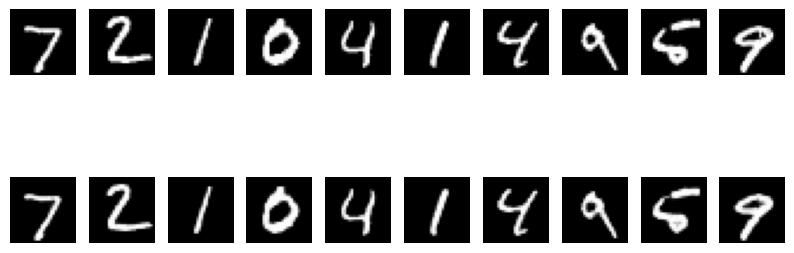

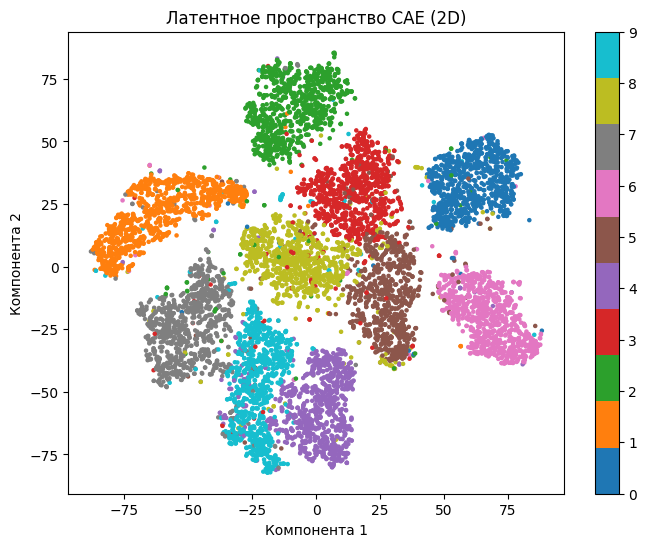

In [25]:
model_cnn = CAE().to(device)
# Функция потерь MSE, т.к. BCE не отражает "качество" модели
criterion = nn.BCELoss()
# Оптимизатор
optimizer = optim.Adam(model_cnn.parameters(), lr=1e-3)

# Обучение модели
for epoch in range(10):
    train_cnn(model_cnn, epoch)

# Визуализация предсказаний
original_cae, recon_cae = visualize_cae_reconstruction(testloader, model_cnn)

# Визуализация латентного пространства
visualize_latent_space_cae(testloader, model_cnn)

In [74]:
# Вычисление метрик
for data, name, eval in zip([original_ae, original_vae, original_cae.reshape(64,784)], ["AE", "VAE", 'CAE'], [recon_ae, recon_vae, recon_cae.reshape(64,784)]):

  mse_val = calculate_mse(data, eval)

  print(f"MSE {name}: {mse_val:>6.5f}")

MSE AE: 0.01236
MSE VAE: 0.01738
MSE CAE: 0.00121


CAE улучшило показатели, т.к.
* CAE использует сверточные слои, которые лучше подходят для работы с изображениями, так как они учитывают пространственную структуру данных (например, локальные паттерны в пикселях).
* Также CAE лучше учитывает локальные зависимости в данных, что приводит к более выраженному разделению классов в латентном пространстве.

## Блок 7. Генерация данных:
* Сгенерировать изображения из случайных точек латентного пространства VAE.
* Провести интерполяцию между двумя точками латентного пространства.
* Исследовать влияние размерности латентного пространства на качество генерации.
* Добавить шум в латентное пространство и оценить влияние на генерацию.


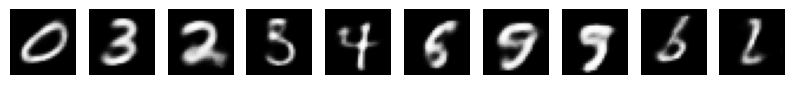

torch.Size([10, 32])

In [82]:
# Генерация случайных точек в латентном пространстве VAE

def generate_images_from_latent(model, num_images=10, latent_dim=32):
    """
    Генерация изображений из случайных точек латентного пространства.
    """
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():
        # Генерация случайных точек в латентном пространстве
        latent_samples = torch.randn(num_images, latent_dim).to(device)

        # Декодирование латентных векторов в изображения
        generated_images = model.decode(latent_samples).cpu().numpy()

        # Визуализация сгенерированных изображений
        plt.figure(figsize=(10, 4))
        for i in range(num_images):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

    return latent_samples

# Пример использования
latent_sample = generate_images_from_latent(model_vae, num_images=10, latent_dim=32)
latent_sample.shape

<ipython-input-83-d5dbbc04b7e8>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_point1 = torch.tensor(latent_point1, dtype=torch.float32).to(device)
<ipython-input-83-d5dbbc04b7e8>:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_point2 = torch.tensor(latent_point2, dtype=torch.float32).to(device)
<ipython-input-83-d5dbbc04b7e8>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intermediate_point = torch.tensor(intermediate_point, dtype=torch.float32).to(device)


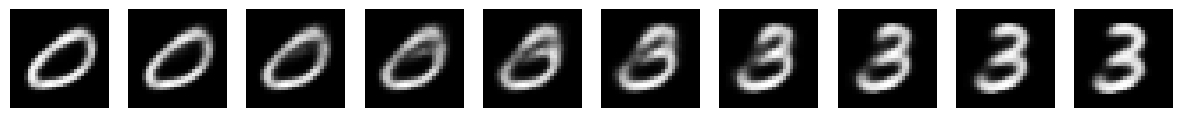

In [83]:
def interpolate_latent_space(model, latent_point1, latent_point2, num_interpolations=10):
    """
    Интерполяция между двумя точками латентного пространства.
    """
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():
        # Линейная интерполяция между двумя точками
        alphas = np.linspace(0, 1, num_interpolations)  # Параметры интерполяции
        interpolated_images = []

        for alpha in alphas:
            # Вычисляем промежуточную точку
            intermediate_point = (1 - alpha) * latent_point1 + alpha * latent_point2
            intermediate_point = torch.tensor(intermediate_point, dtype=torch.float32).to(device)

            # Декодируем промежуточную точку в изображение
            generated_image = model.decode(intermediate_point).cpu().numpy()
            interpolated_images.append(generated_image)

        # Визуализация интерполяции
        plt.figure(figsize=(15, 2))
        for i, image in enumerate(interpolated_images):
            plt.subplot(1, num_interpolations, i + 1)
            plt.imshow(image.reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

# Пример использования
# Выбираем две случайные точки из латентного пространства
latent_point1 = latent_sample[0]  # Первая точка
latent_point2 = latent_sample[1]  # Вторая точка

# Преобразуем в тензоры и перемещаем на устройство
latent_point1 = torch.tensor(latent_point1, dtype=torch.float32).to(device)
latent_point2 = torch.tensor(latent_point2, dtype=torch.float32).to(device)

# Проводим интерполяцию
interpolate_latent_space(model_vae, latent_point1, latent_point2, num_interpolations=10)

Вот так происходит интерполяция, т.е. VAE пытается найти промежуточные изображения, которые плавно соединяют 0 и 3.

In [129]:
# Для исследования влмяния размерности латентного пространства на качество давайте сгенируем изображения в размерностях [16, 32]
# инициализация модели и оптимизатора
model_vae_16 = VAE(latent_dim=16).to(device)
optimizer = optim.Adam(model_vae_16.parameters(), lr=1e-3)

# Обучение модели
epochs = 10
for epoch in range(1, epochs + 1):
    train(model_vae_16, epoch, 0.1)

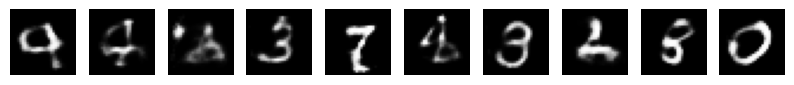

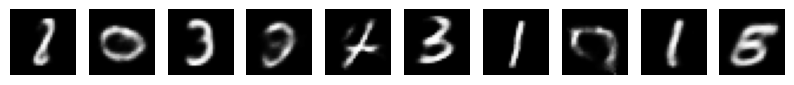

In [131]:
# Пример использования
latent_sample_16 = generate_images_from_latent(model_vae_16, num_images=10, latent_dim=16)
latent_sample_32 = generate_images_from_latent(model_vae, num_images=10, latent_dim=32)

Изображения получились менее четкими

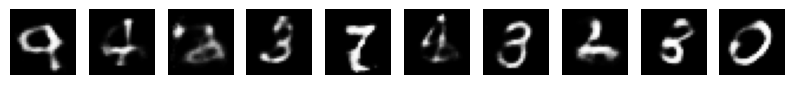

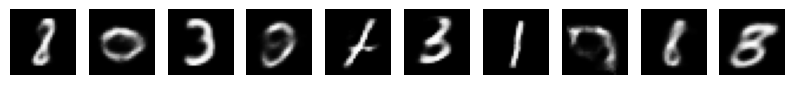

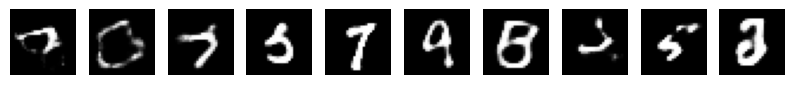

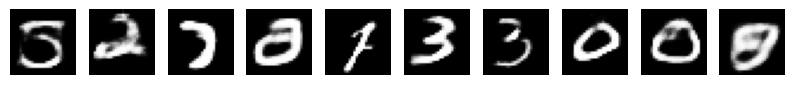

In [135]:
def add_noise_and_generate(model, z, noise_std=0.1):
    """
    Добавление шума в латентное пространство и генерация изображений.
    """
    model.eval()
    with torch.no_grad():
        # Добавляем шум
        noise = torch.randn_like(z) * noise_std
        z_noisy = z + noise
        # Декодируем
        generated_images = model.decode(z_noisy).cpu()

    # Визуализация
    plt.figure(figsize=(10, 2))
    for i in range(len(z)):
        plt.subplot(1, len(z), i+1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Пример использования
add_noise_and_generate(model_vae_16, latent_sample_16, noise_std=0.2)
add_noise_and_generate(model_vae, latent_sample_32, noise_std=0.2)

add_noise_and_generate(model_vae_16, latent_sample_16, noise_std=2)
add_noise_and_generate(model_vae, latent_sample_32, noise_std=2)

# Значительное увеличение шума привело к удалению контуров и в случае последних изменило их форму

## Блок 8. Сравнение VAE и GAN:
* Реализовать простую архитектуру GAN для генерации изображений.
* Сравнить качество изображений, сгенерированных VAE и GAN.
* Провести интерполяцию в латентном пространстве GAN.


In [137]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

# Инициализация GAN
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Применяем инициализацию
generator.apply(weights_init)
discriminator.apply(weights_init)


optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Обучение GAN
for epoch in range(10):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for i, (imgs, _) in enumerate(progress_bar):
        imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Обучение дискриминатора
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

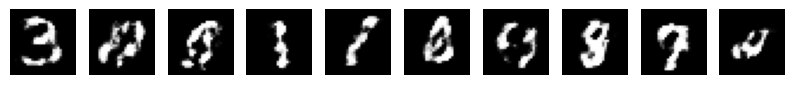

In [139]:
# Генерация изображений с помощью GAN
z = torch.randn(10, latent_dim).to(device)
generated_images = generator(z)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
# Инициализация GAN
latent_dim = 100
generator1 = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Применяем инициализацию
generator1.apply(weights_init)
discriminator.apply(weights_init)


optimizer_G = optim.Adam(generator1.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()

# Обучение GAN
for epoch in range(30):
    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for i, (imgs, _) in enumerate(progress_bar):
        imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # Обучение дискриминатора
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs), real_labels)
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator1(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator1(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        progress_bar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())


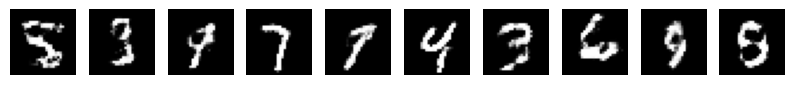

In [149]:
generated_images = generator1(z)

# Визуализация сгенерированных изображений
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

Модель GAN более требовательны к обучению поэтому даже после 30 эпох результат менее удачный, чем у VAE

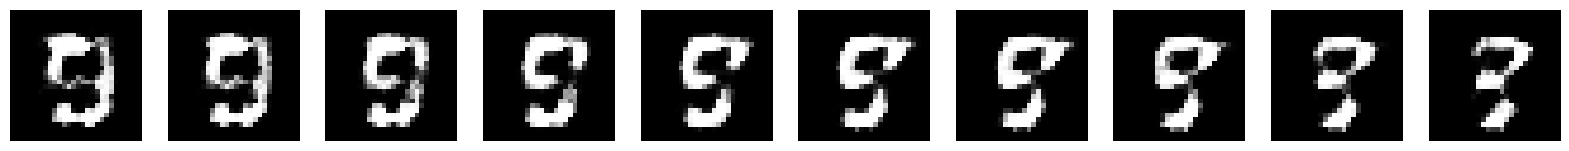

In [147]:
def interpolate(generator, z1, z2, num_steps=10):
    """
    Интерполяция между двумя точками в латентном пространстве.
    """
    # Создаем интерполяционные коэффициенты
    alpha = torch.linspace(0, 1, num_steps).to(z1.device)

    # Интерполируем между z1 и z2
    interpolated_images = []
    for a in alpha:
        z = a * z2 + (1 - a) * z1
        with torch.no_grad():
            generated_image = generator(z).cpu()
        interpolated_images.append(generated_image)

    return interpolated_images

latent_dim = 100
# Пример использования
z1 = torch.randn(1, latent_dim).to(device)  # Первый латентный вектор
z2 = torch.randn(1, latent_dim).to(device)  # Второй латентный вектор

interpolated_images = interpolate(generator, z1, z2, num_steps=10)

# Визуализация интерполяции
fig, axes = plt.subplots(1, len(interpolated_images), figsize=(20, 2))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()